What's been done here?
1. Merge GTEX params and network params.
2. Calculate mean neighbor zscore and breadth.
3. Clean the gt_param_df and remove unnecessary columns

code referred from - http://localhost:4321/notebooks/azure-backup-notebooks/min_gene_analysis/Min_gene_N10.ipynb

End product - Looks like below - Available at 

/scratch1/gowthami/GTF/GTF_Project_v2/data/gt_param_df.csv

What more needs to be done?
1. Add POS & NEG from HPA

Notes:

__What's the breadth here?__

_Threshold is 25 percentile value of gene expression of any given gene across all the tissues. Breadth is percentage of samples above that threshold in a given tissue_

MADM param has around 12000 Nan values in gtex_params df, so what I have done is removed the nulls only from Zscore and CV columns and not from MADM column. After merging GTEX param and Graph params, i ended up with 0 null values in MADM tab as well, so it worked out.

In [47]:
gt_param_df.head(2)

,Gene,Tissue,ZScore,Breadth,CV,MADM,Centrality_coeff,Clustering_coeff,IsKinase,IsTF,NumOfKinaseNbs,NumOfNeighbors,NumOfTFNeighbors,NeighborMeanBreadth,NeighborMeanZscore
0,A1BG,Adipose Tissue,-0.121740,0.898369,0.621098,0.483348,0.001653,0.036364,0,0,0,11,0,0.857534,0.021100
1,A1BG,Blood,-0.125674,0.623836,0.859649,0.765763,0.000898,0.000000,0,0,0,2,0,0.675978,-0.146973


In [1]:
import pandas as pd
import csv
import numpy as np
import scipy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=40,20
import matplotlib.mlab as mlab
from IPython.display import display
pd.options.display.max_columns = None
from numpy import random
from statsmodels import robust
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import itertools
import networkx as nx
import datetime


In [2]:
graph_params = pickle.load( open( "./data_generated/network_generated/gt_graph_param_df.p", "rb" ) )
gtex_params = pickle.load(open('./data_generated/gt_exp_param_df.p','rb'))
gtex_params = gtex_params.rename(columns={"CoeffOfVar": "CV",
                                          "MedAbsDev":"MAD"})

graph_centrality = pickle.load( 
    open( "./data_generated/network_generated/all_tissue_centrality.p", "rb" ) )
graph_params = pd.merge(graph_params, graph_centrality,  how='inner', 
                       left_on=['Gene','Tissue'], right_on = ['Gene','Tissue'])

In [3]:
graph_params.head(2)

,Clustering_coeff,Gene,IsKinase,IsTF,NeighborList,NumOfKinaseNbs,NumOfNeighbors,NumOfTFNeighbors,Tissue,Centrality_coeff
0,0.100000,ENSG00000165092,0,0,"[ENSG00000165092, ENSG00000176046, ENSG0000011...",0,7,1,Small Intestine,0.000001
1,0.062678,ENSG00000158528,0,0,"[ENSG00000184009, ENSG00000188191, ENSG0000018...",0,29,1,Small Intestine,0.000020


In [4]:
gtex_params.head(2)

,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CV,MAD
0,ENSG00000187634,Stomach,4.720096,4.267317,-0.036851,3.423000,0.763231,0.904074,2.489289
1,ENSG00000188976,Stomach,44.847466,15.854806,-0.412520,42.380001,0.220056,0.353527,14.366420


In [5]:
graph_params['Tissue'].value_counts()

Testis             15619
Kidney             15505
Brain              15500
Pituitary          15439
Salivary Gland     15420
Pancreas           15370
Breast             15334
Prostate           15298
Spleen             15254
Thyroid            15251
Vagina             15250
Heart              15232
Small Intestine    15223
Adipose Tissue     15222
Adrenal Gland      15166
Lung               15146
Ovary              15146
Stomach            15136
Nerve              15102
Esophagus          15098
Colon              15084
Uterus             14996
Cervix Uteri       14981
Liver              14981
Skin               14959
Muscle             14924
Blood Vessel       14894
Blood              14884
Bladder            14515
Fallopian Tube     13526
Name: Tissue, dtype: int64

In [6]:
gtex_params['Tissue'].value_counts()

Blood              16620
Ovary              16620
Uterus             16620
Adrenal Gland      16620
Testis             16620
Kidney             16620
Liver              16620
Esophagus          16620
Small Intestine    16620
Stomach            16620
Blood Vessel       16620
Muscle             16620
Fallopian Tube     16620
Breast             16620
Prostate           16620
Brain              16620
Thyroid            16620
Skin               16620
Adipose Tissue     16620
Lung               16620
Cervix Uteri       16620
Heart              16620
Colon              16620
Nerve              16620
Salivary Gland     16620
Pituitary          16620
Pancreas           16620
Spleen             16620
Bladder            16620
Vagina             16620
Name: Tissue, dtype: int64

In [7]:
print(gtex_params.shape)
print(graph_params.shape)

(498600, 9)
(453455, 10)


In [8]:
graph_params.isnull().any()


Clustering_coeff    False
Gene                False
IsKinase            False
IsTF                False
NeighborList        False
NumOfKinaseNbs      False
NumOfNeighbors      False
NumOfTFNeighbors    False
Tissue              False
Centrality_coeff    False
dtype: bool

In [9]:
gtex_params.isnull().any()


Gene         False
Tissue       False
MeanExp      False
SDofExp      False
ZScore        True
MedianExp    False
Breadth      False
CV            True
MAD          False
dtype: bool

In [10]:
nan_genes = pd.DataFrame(gtex_params[gtex_params.isna().any(axis=1)]['Gene'].drop_duplicates().tolist())
nan_genes.to_csv('./data_generated/genes_withnan_zs_or_cv')

In [11]:
gtex_params = gtex_params[np.isfinite(gtex_params['ZScore'])]
gtex_params = gtex_params[np.isfinite(gtex_params['CV'])]

In [12]:
gtex_params.isnull().any()


Gene         False
Tissue       False
MeanExp      False
SDofExp      False
ZScore       False
MedianExp    False
Breadth      False
CV           False
MAD          False
dtype: bool

In [13]:
print(gtex_params.shape)
gtex_params.head()

(496503, 9)


,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CV,MAD
0,ENSG00000187634,Stomach,4.720096,4.267317,-0.036851,3.423000,0.763231,0.904074,2.489289
1,ENSG00000188976,Stomach,44.847466,15.854806,-0.412520,42.380001,0.220056,0.353527,14.366420
2,ENSG00000187961,Stomach,11.037735,4.394696,-0.145059,10.360000,0.445682,0.398152,3.558246
3,ENSG00000187583,Stomach,1.643722,1.750657,-0.314139,1.138000,0.682451,1.065057,1.040194
4,ENSG00000187642,Stomach,0.612194,0.432204,-0.298348,0.489900,0.454039,0.705991,0.274874


In [14]:
gt_param_df = pd.merge(gtex_params, graph_params,  how='inner', 
                       left_on=['Gene','Tissue'], right_on = ['Gene','Tissue'])


print(gt_param_df.shape)
gt_param_df.head(4)

(453455, 17)


,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CV,MAD,Clustering_coeff,IsKinase,IsTF,NeighborList,NumOfKinaseNbs,NumOfNeighbors,NumOfTFNeighbors,Centrality_coeff
0,ENSG00000187634,Stomach,4.720096,4.267317,-0.036851,3.423000,0.763231,0.904074,2.489289,0.047619,0,0,"[ENSG00000128591, ENSG00000121060, ENSG0000011...",0,7,2,1.209951e-06
1,ENSG00000188976,Stomach,44.847466,15.854806,-0.412520,42.380001,0.220056,0.353527,14.366420,0.253545,0,0,"[ENSG00000111676, ENSG00000166333, ENSG0000017...",2,110,15,9.446877e-05
2,ENSG00000187961,Stomach,11.037735,4.394696,-0.145059,10.360000,0.445682,0.398152,3.558246,0.333333,0,0,"[ENSG00000159251, ENSG00000036257, ENSG0000001...",0,4,0,2.254576e-07
3,ENSG00000187583,Stomach,1.643722,1.750657,-0.314139,1.138000,0.682451,1.065057,1.040194,0.000000,0,0,"[ENSG00000185002, ENSG00000110031, ENSG0000016...",0,3,1,5.063642e-07


In [15]:
gt_param_df.isnull().any()


Gene                False
Tissue              False
MeanExp             False
SDofExp             False
ZScore              False
MedianExp           False
Breadth             False
CV                  False
MAD                 False
Clustering_coeff    False
IsKinase            False
IsTF                False
NeighborList        False
NumOfKinaseNbs      False
NumOfNeighbors      False
NumOfTFNeighbors    False
Centrality_coeff    False
dtype: bool

# Calculating MeanZscore & Mean breadth of neighbors

In [16]:
tissue_list = gt_param_df['Tissue'].drop_duplicates().tolist()
gene_list = gt_param_df['Gene'].drop_duplicates().tolist()
breadth_dict = {}
zscore_dict = {}
for tissue in tissue_list:
    breadth_dict[tissue] = {}
    zscore_dict[tissue] = {}


In [17]:
count = 0
for index,row in gt_param_df.iterrows():
    count+=1
    gene = row['Gene']
    tissue = row['Tissue']
    breadth_dict[tissue][gene] = row['Breadth']
    zscore_dict[tissue][gene] = row['ZScore']
    if count%10000 ==  0:
        print(count)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000


In [ ]:
count = 0
mean_breadth_list = []
mean_zscore_list = []
median_breadth_list = []
median_zscore_list = []

for index,row in gt_param_df.iterrows():
    count+=1
    tissue = row['Tissue']
    nl = row['NeighborList']
#     print(tissue)
    if nl == 0:
        mean_breadth_list.append(0)
        mean_zscore_list.append(0)
    else:
        nl = list(set(nl)&set(gene_list))
        mean_breadth = np.mean([breadth_dict[tissue][x] for x in nl])
        mean_zscore = np.mean([zscore_dict[tissue][x] for x in nl])
        median_breadth = np.median([breadth_dict[tissue][x] for x in nl])
        median_zscore = np.median([zscore_dict[tissue][x] for x in nl])
        mean_breadth_list.append(mean_breadth)
        mean_zscore_list.append(mean_zscore)
        median_breadth_list.append(median_breadth)
        median_zscore_list.append(median_zscore)
    if count%10000 ==  0:
        print(count)
        
gt_param_df['NeighborMeanBreadth'] = mean_breadth_list
gt_param_df['NeighborMeanZscore'] = mean_zscore_list
gt_param_df['NeighborMedianBreadth'] = median_breadth_list
gt_param_df['NeighborMedianZscore'] = median_zscore_list



10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000


In [ ]:
print(gt_param_df.shape)
gt_param_df.head(2)

In [ ]:
gt_param_df['Tissue'].value_counts()

In [ ]:
gt_param_df.head()

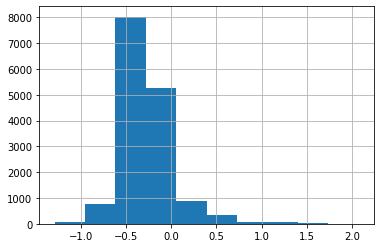

In [26]:
gt_param_df[gt_param_df['Tissue'] == 'Brain']['NeighborMeanZscore'].hist()

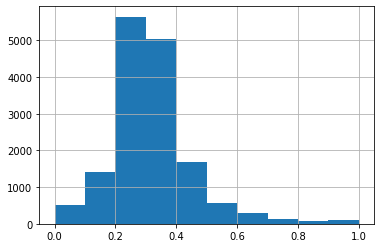

In [27]:
gt_param_df[gt_param_df['Tissue'] == 'Brain']['NeighborMeanBreadth'].hist()

In [28]:
gene_lookup_dict_ensg2name = pickle.load( 
    open( "./data_generated/ens2gname_lookup.p", "rb" ) )


In [29]:
gt_param_df["Description"] = gt_param_df["Gene"].map(gene_lookup_dict_ensg2name)
gt_param_df.to_csv('./data_generated/gt_param_df.csv',index=False)
pickle.dump( gt_param_df, open( "./data_generated/gt_param_df.p", "wb" ) )

In [30]:
gt_param_df.head()

,Gene,Tissue,MeanExp,SDofExp,ZScore,MedianExp,Breadth,CV,MAD,Clustering_coeff,IsKinase,IsTF,NeighborList,NumOfKinaseNbs,NumOfNeighbors,NumOfTFNeighbors,Centrality_coeff,NeighborMeanBreadth,NeighborMeanZscore,NeighborMedianBreadth,NeighborMedianZscore,Description
0,ENSG00000187634,Stomach,4.720096,4.267317,-0.036851,3.423000,0.763231,0.904074,2.489289,0.047619,0,0,"[ENSG00000128591, ENSG00000121060, ENSG0000011...",0,7,2,1.209951e-06,0.296060,-0.366241,0.261838,-0.380078,SAMD11
1,ENSG00000188976,Stomach,44.847466,15.854806,-0.412520,42.380001,0.220056,0.353527,14.366420,0.253545,0,0,"[ENSG00000111676, ENSG00000166333, ENSG0000017...",2,110,15,9.446877e-05,0.349456,-0.245143,0.309192,-0.260509,NOC2L
2,ENSG00000187961,Stomach,11.037735,4.394696,-0.145059,10.360000,0.445682,0.398152,3.558246,0.333333,0,0,"[ENSG00000159251, ENSG00000036257, ENSG0000001...",0,4,0,2.254576e-07,0.300836,-0.350367,0.274373,-0.335166,KLHL17
3,ENSG00000187583,Stomach,1.643722,1.750657,-0.314139,1.138000,0.682451,1.065057,1.040194,0.000000,0,0,"[ENSG00000185002, ENSG00000110031, ENSG0000016...",0,3,1,5.063642e-07,0.470752,0.818392,0.284123,-0.294220,PLEKHN1
4,ENSG00000187642,Stomach,0.612194,0.432204,-0.298348,0.489900,0.454039,0.705991,0.274874,0.000000,0,0,[ENSG00000160789],0,1,0,0.000000e+00,0.311978,-0.253442,0.311978,-0.253442,PERM1


In [32]:
gt_param_df.isnull().any()


Gene                     False
Tissue                   False
MeanExp                  False
SDofExp                  False
ZScore                   False
MedianExp                False
Breadth                  False
CV                       False
MAD                      False
Clustering_coeff         False
IsKinase                 False
IsTF                     False
NeighborList             False
NumOfKinaseNbs           False
NumOfNeighbors           False
NumOfTFNeighbors         False
Centrality_coeff         False
NeighborMeanBreadth      False
NeighborMeanZscore       False
NeighborMedianBreadth    False
NeighborMedianZscore     False
Description              False
dtype: bool